# Time Since

The recency of events measure the time between events. For example, if we have a charity, we could be interested in the time since our supporter's last donation. This could be a good indicator of our ability to bring supporters back and thus raise more money for our campaigns. And this capacity could in turn be a good feature to forecast money raised monthly or weekly.

In this notebook, we are going to determine the time since the last transaction for our customers. Then we are going to aggregate this value across all our customers. And finally, we are going to make a very superficial analysis to try and understand if this feature is informative of weekly sales.

This is just scratching the surface of what is possible. We could derive more features like:

- Time since first transaction
- Time since the most expensive transaction
- Time since the cheapest transaction

And any other feature you can think of, that is relevant for your organization.

Once we have these metrics for each of our customers, we can aggregate them weekly, monthly, daily, depending on our forecast intention.

In this notebook, we will calculate the time since last purchase with pandas, and in the next notebook we will automate this procedure, deriving even more features, with Featuretools.


## The dataset

We will use the Online Retail II Data Set available in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II).

Download the xlsx file and save it in the **Datasets** folder within this repo.

**Citation**:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

## In this demo

We will extract different features from the datetime variable: **InvoiceDate**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

## Load the data

In [2]:
# File path
file = '../Datasets/online_retail_II.xlsx'

# The data is provided as two sheets in a single Excel file.
# Each sheet contains a different time period.
# Load both and join into a single dataframe.

df_1 = pd.read_excel(file, sheet_name='Year 2009-2010')
df_2 = pd.read_excel(file, sheet_name='Year 2010-2011')

data = pd.concat([df_1, df_2])

print(data.shape)

data.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In this dataset, we have the datetime variable in a column: InvoiceDate. We could also have it in the dataframe index. The procedure to extract the datetime features is similar.

FYI, the dataset contains sales information for different customers in different countries. Customers may have done 1 or multiple purchases to the business that provided the data.

We will determine, for each customer's transaction, the time since the previous transaction.

In [3]:
# Drop data for unknown customers

data.dropna(subset=['Customer ID'], inplace=True)

print(data.shape)

(824364, 8)


In [4]:
# Work only with sales in the UK

data = data[data['Country']=='United Kingdom']

In [5]:
# Remove orders that were cancelled

cancelled = data['Invoice'].apply(lambda x: str(x)[0] == 'C')
data = data[~cancelled]

In [6]:
# Number of unique customers in the UK

data['Customer ID'].nunique()

5353

## Time since last transaction

Transaction Recency measures the time between the customer's purchases. It is a way of measuring the business's ability to bring customers back.

Text(0.5, 0, 'Number of purchases per customer')

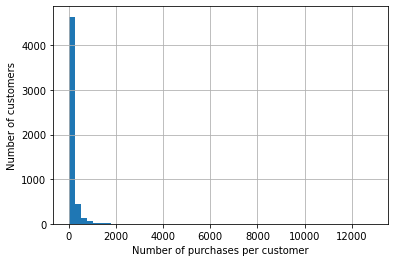

In [7]:
# First: do our customers purchase from us more than once?

data.groupby('Customer ID')['InvoiceDate'].count().hist(bins=50)
plt.ylabel('Number of customers')
plt.xlabel('Number of purchases per customer')

Text(0.5, 0, 'Number of purchases per customer')

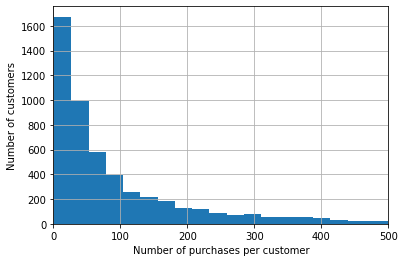

In [8]:
# Zooming in

data.groupby('Customer ID')['InvoiceDate'].count().hist(bins=500)
plt.xlim(0,500)
plt.ylabel('Number of customers')
plt.xlabel('Number of purchases per customer')

Most of our customers seem to make purchases only once or very few times, but we have certainly some loyal customers that make repeated purchases.

If we wanted to forecast our weekly sales, knowing how often our customers come back to us may be helpful.

In [9]:
# First, let's sort the data per customer and per invoice date
# just in case it was not sorted

data.sort_values(by=['Customer ID', 'InvoiceDate'], ascending=True, inplace=True)

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346.0,United Kingdom
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346.0,United Kingdom
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346.0,United Kingdom
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346.0,United Kingdom
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346.0,United Kingdom


In [10]:
data.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
392752,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287.0,United Kingdom
392753,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287.0,United Kingdom
423939,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287.0,United Kingdom
423940,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287.0,United Kingdom
423941,573167,21014,SWISS CHALET TREE DECORATION,24,2011-10-28 09:29:00,0.29,18287.0,United Kingdom


In [11]:
# Now, we determine the time since the last transaction,
# per customer

data['time_since'] = data.groupby('Customer ID')['InvoiceDate'].diff()

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,time_since
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346.0,United Kingdom,NaT
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346.0,United Kingdom,0 days 02:26:00
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346.0,United Kingdom,0 days 00:02:00
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346.0,United Kingdom,3 days 23:45:00
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346.0,United Kingdom,0 days 00:08:00


In [12]:
data.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,time_since
392752,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287.0,United Kingdom,0 days 00:00:00
392753,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287.0,United Kingdom,0 days 00:00:00
423939,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287.0,United Kingdom,15 days 23:06:00
423940,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287.0,United Kingdom,0 days 00:00:00
423941,573167,21014,SWISS CHALET TREE DECORATION,24,2011-10-28 09:29:00,0.29,18287.0,United Kingdom,0 days 00:00:00


In [13]:
# Now it seems that we are better off calculating time elapsed in minutes
# so let's do that

data['time_since'] = data.groupby('Customer ID')['InvoiceDate'].diff() /np.timedelta64(1,'m')

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,time_since
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346.0,United Kingdom,NaN
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346.0,United Kingdom,146.0
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346.0,United Kingdom,2.0
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346.0,United Kingdom,5745.0
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346.0,United Kingdom,8.0


In [14]:
data.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,time_since
392752,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287.0,United Kingdom,0.0
392753,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287.0,United Kingdom,0.0
423939,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287.0,United Kingdom,22986.0
423940,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287.0,United Kingdom,0.0
423941,573167,21014,SWISS CHALET TREE DECORATION,24,2011-10-28 09:29:00,0.29,18287.0,United Kingdom,0.0


For more details on how to determine differences in another time units, visit [this article](http://www.datasciencemadesimple.com/difference-two-timestamps-seconds-minutes-hours-pandas-python-2/).

In [15]:
# Calculate revenue per customer per transaction

data['Revenue'] = data['Quantity'] * data['Price']

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,time_since,Revenue
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346.0,United Kingdom,NaN,45.0
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346.0,United Kingdom,146.0,22.5
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346.0,United Kingdom,2.0,22.5
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346.0,United Kingdom,5745.0,22.5
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346.0,United Kingdom,8.0,1.0


Now, say we want to forecast weekly sales. We will re-structure the data to have sales volume per week. And thus, we will aggregate the time_since that we have per customer, across all customers who made purchases each week.

In [16]:
df_gross = pd.concat([
    # weekly volume of sales
    (data.loc[:, ['InvoiceDate', 'Revenue']]
    .resample('W', on='InvoiceDate')
    .sum()
    ),
    # mean time_since, across customers, per week
    (data.loc[:, ['InvoiceDate', 'time_since']]
    .resample('W', on='InvoiceDate')
    .mean()
    ),
], axis=1)


df_gross.shape

(106, 2)

In [17]:
# the resulting data

df_gross.head()

,Revenue,time_since
InvoiceDate,,
2009-12-06,213000.35,6.819045
2009-12-13,195810.04,99.193534
2009-12-20,182396.74,300.119979
2009-12-27,22007.77,546.805890
2010-01-03,0.00,NaN


To forecast sales, we would derive features as we learned throughout the course and use them along side date and time features and perhaps the time_since feature.

Here, we would just make some high level data visualization.

Text(0.5, 0, 'Time')

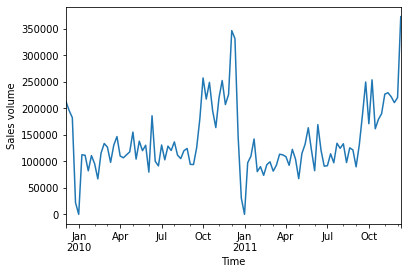

In [18]:
# weekly revenue

df_gross['Revenue'].plot()
plt.ylabel('Sales volume')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

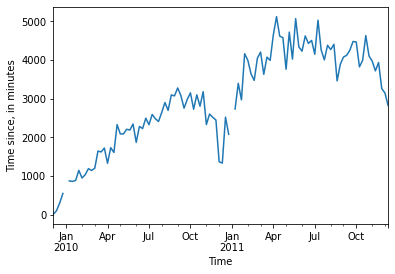

In [20]:
# mean time between purchases for customers, weekly

df_gross['time_since'].plot()
plt.ylabel('Time since, in minutes')
plt.xlabel('Time')

Text(0.5, 0, 'Time since, in minutes')

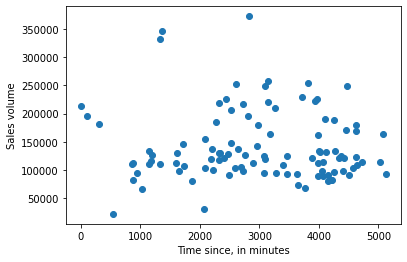

In [21]:
# And now, why not, a scatter plot between the 2

plt.scatter(df_gross['time_since'], df_gross['Revenue'])
plt.ylabel('Sales volume')
plt.xlabel('Time since, in minutes')